In [1]:
import wepppy
from os.path import join as _join
from os.path import exists as _exists
from os.path import split as _split
from operator import itemgetter
import json

import numpy as np
import cv2

from osgeo import gdal, osr

from subprocess import Popen, PIPE

from wepppy.all_your_base.geo import read_raster
from wepppy.all_your_base.geo import get_utm_zone, utm_srid

In [2]:
from ipywidgets import Layout
from ipyleaflet import (
    Map, 
    basemaps, 
    basemap_to_tiles, 
    GeoJSON, 
    LayersControl, 
    ImageOverlay
)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sidecar

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
from osgeo import gdal

def write_raster(dst_fn, data, proj4, transform, datatype, nodata=None):
    # initialize raster
    num_cols, num_rows = data.shape
    driver = gdal.GetDriverByName("GTiff")
    dst = driver.Create(dst_fn, num_cols, num_rows,
                        1, datatype)

    srs = osr.SpatialReference()
    srs.ImportFromProj4(proj4)
    wkt = srs.ExportToWkt()

    dst.SetProjection(wkt)
    dst.SetGeoTransform(transform)
    band = dst.GetRasterBand(1)
    band.WriteArray(data.T)
    if nodata is not None:
        band.SetNoDataValue(nodata)
        
    del dst

In [6]:
# 2m lidar  (>200 hillslopes)
#wd = '/geodata/weppcloud_runs/rlew-speechless-coastline/'

# # 10m resolution NED DEM (28 hillslopes)
# wd = '/geodata/weppcloud_runs/rlew-adoring-eighteen/'

# 5m resolution from 2m DEM (45 hillslopes)
# start with this one
wd='/geodata/weppcloud_runs/offensive-materiel/'

In [9]:
from wepppy.nodb import Watershed

watershed = Watershed.getInstance(wd)

FileNotFoundError: [Errno 2] No such file or directory: '/geodata/weppcloud_runs/offensive-materiel/watershed.nodb'

In [9]:
!gdalinfo {watershed.dem_fn}

Driver: GTiff/GeoTIFF
Files: /geodata/weppcloud_runs/offensive-materiel/dem/dem.tif
       /geodata/weppcloud_runs/offensive-materiel/dem/dem.tif.aux.xml
Size is 217, 227
Coordinate System is:
PROJCS["WGS 84 / UTM zone 11N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32611"]]
Origin = (360904.995939461106900,53647

In [10]:
ron = wepppy.nodb.Ron.getInstance(wd)

In [11]:
ron.map.center, ron.map.zoom, watershed.channels_shp, watershed.subwta_shp, watershed.subwta, watershed.sub_n

([-118.8725, 48.4151],
 16,
 '/geodata/weppcloud_runs/offensive-materiel/dem/topaz/CHANNELS.WGS.JSON',
 '/geodata/weppcloud_runs/offensive-materiel/dem/topaz/SUBCATCHMENTS.WGS.JSON',
 '/geodata/weppcloud_runs/offensive-materiel/dem/topaz/SUBWTA.ARC',
 45)

In [12]:
ron.extent

[-118.8800096511841, 48.410117877891764, -118.8649892807007, 48.42008733448947]

In [13]:
!ls /geodata/weppcloud_runs/rlew-speechless-coastline/dem/topaz/

BOUND.ARC	   ELVCLA.OUT	NETFUL.WGS.JSON  RELIEF.ARC
BOUND.JSON	   FILDEP.OUT	NETW.ARC	 RELIEF.OUT
BOUND.OUT	   FLOPAT.ARC	NETWE.OUT	 RELIEF.PRJ
BOUND.PRJ	   FLOPAT.OUT	NETW.OUT	 SBCT.TAB
BOUND.WGS.JSON	   FLOPAT.PRJ	NETW.PRJ	 SUBBDA.OUT
CHANNELS.JSON	   FLOVEC.ARC	NETW.TAB	 SUBBDB.OUT
CHANNELS.WGS.JSON  FLOVEC.OUT	NTGCOD.OUT	 SUBCATCHMENTS.JSON
CHNJNT.ARC	   FLOVEC.PRJ	NTWINT.FIL	 SUBCATCHMENTS.WGS.JSON
CHNJNT.PRJ	   FVASPE.OUT	OUTCAT.UNF	 SUBWTA.ARC
dednm		   FVSLOP.ARC	OUTCHA.UNF	 SUBWTA.JSON
DEDNM.INP	   FVSLOP.OUT	OUTCNT.UNF	 SUBWTA.OUT
dednm.log	   FVSLOP.PRJ	rasfor		 SUBWTA.PRJ
DEPFLT.OUT	   HSLOPE.OUT	RASFOR.INP	 SUBWTB.OUT
DISCHA.OUT	   INDTAR.OUT	rasfor.log	 TASPEC.ARC
DISOUT.OUT	   INELEV.OUT	RASFOR.RPT	 TASPEC.OUT
DNMCNT.INP	   NETFUL.ARC	raspro		 TASPEC.PRJ
ELDCHA.OUT	   NETFUL.JSON	RASPRO.INP	 TSLOPE.OUT
ELDOUT.OUT	   NETFUL.OUT	raspro.log	 UPAREA.OUT
ELVBND.TAB	   NETFUL.PRJ	RASPRO.RPT


In [14]:

m = Map(
    basemap=basemap_to_tiles(basemaps.Esri.WorldTopoMap),
    center=ron.map.center[::-1],
    zoom=ron.map.zoom,
    layout=Layout(width='100%', height='1000px')
    )


# Skid Trials
skid_trials_fn = '/geodata/salvage_logging/north_star/Skid_segments.wgs.geojson'
with open(skid_trials_fn) as fp:
    skid_trails = json.load(fp)
    
skid_trails_geojson = GeoJSON(
    data=skid_trails,
    style={
        'opacity': 1, 'fillOpacity': 0.1, 'weight': 1, 'color': 'purple'
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5
    }, name='Skid Trails'
)
m.add_layer(skid_trails_geojson)


# Channels
with open(watershed.channels_shp) as fp:
    channels = json.load(fp)
    
channels_geojson = GeoJSON(
    data=channels,
    style={
        'opacity': 1, 'fillOpacity': 0.1, 'weight': 1, 'color': 'blue'
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5
    }, name='Channels'
)
m.add_layer(channels_geojson)


# Subcatchments
with open(watershed.subwta_shp) as fp:
    subcatchments = json.load(fp)
    
subcatchments_geojson = GeoJSON(
    data=subcatchments,
    style={
        'opacity': 1, 'fillOpacity': 0.1, 'weight': 1, 'color': 'orange'
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5
    }, name='SubCatchments'
)
m.add_layer(subcatchments_geojson)

# Layers Control
control = LayersControl(position='topright')
m.add_control(control)

In [15]:
m

Map(center=[48.4151, -118.8725], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [16]:
xll = -9999
yll = -9999
cellsz = -9999
nrows = -9999
ncols = -9999

In [17]:
# check if the working directory for soils exists, if not create it
import os
roads_dir = _join(wd, 'roads')

if not _exists(roads_dir):
    os.mkdir(roads_dir)

In [18]:

dem_fn = watershed.dem_fn

# open the dataset
ds = gdal.Open(dem_fn)

# read and verify the num_cols and num_rows
num_cols = ds.RasterXSize
num_rows = ds.RasterYSize

if num_cols <= 0 or num_rows <= 0:
    raise Exception('input is empty')

# read and verify the _transform
_transform = ds.GetGeoTransform()

if abs(_transform[1]) != abs(_transform[5]):
    raise Exception('input cells are not square')

cellsize = abs(_transform[1])
ul_x = int(round(_transform[0]))
ul_y = int(round(_transform[3]))

lr_x = ul_x + cellsize * num_cols
lr_y = ul_y - cellsize * num_rows

ll_x = int(ul_x)
ll_y = int(lr_y)

# read the projection and verify dataset is in utm
srs = osr.SpatialReference()
srs.ImportFromWkt(ds.GetProjectionRef())

datum, utm_zone, hemisphere = get_utm_zone(srs)
epsg = utm_srid(utm_zone, hemisphere == 'N')
epsg

'32611'

In [19]:

road_utm_fn = '/geodata/salvage_logging/north_star/Skid_segments.utm.geojson'

In [20]:
!cat {road_utm_fn}

{
"type": "FeatureCollection",
"name": "Skid_segments",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::32611" } },
"features": [
{ "type": "Feature", "properties": { "CFF_ID": 0, "NAME": null, "DATA_SOURC": null, "COLLECTION": null, "CFF_CODE": 0, "CFF_CODELI": null, "SUPPRESSIO": null, "GNIS_ID": null, "FCSUBTYPE": 0, "LOCATION": 0, "COMPOSITIO": 0, "INTERSTATE": null, "US_ROUTE": null, "STATE_ROUT": null, "COUNTY_ROU": null, "RTE_NO": null, "SHAPE_Leng": 0.0 }, "geometry": { "type": "LineString", "coordinates": [ [ 361447.799922294216231, 5364591.635406527668238 ], [ 361454.139031954458915, 5364587.078069101087749 ], [ 361462.191502743517049, 5364583.396049581468105 ], [ 361471.795700396411121, 5364581.747444981709123 ], [ 361476.170358332747128, 5364572.268920351751149 ], [ 361483.322298411803786, 5364562.824920433573425 ], [ 361484.591309840558097, 5364548.113357395865023 ], [ 361485.61260922497604, 5364538.794600233435631 ] ] } },
{ "type": "Feature", "pro

In [21]:
dilation = 1  # 6 m wide skid trail

road_mask_fn = _join(roads_dir, 'road_mask.tif')
cmd = ['gdal_rasterize', '-burn', 1, '-a_nodata', '0',
       '-a_srs', 'epsg:{}'.format(epsg), 
       '-te', ul_x, lr_y, lr_x, ul_y,
       '-tr', cellsize, cellsize,
       '-ot', 'UInt16', road_utm_fn, road_mask_fn]
cmd = [str(v) for v in cmd]
print(' '.join(cmd))

p = Popen(cmd, stdout=PIPE, stderr=PIPE)
p.wait()
assert _exists(road_mask_fn)

mask, _transform, _proj = read_raster(road_mask_fn)
kernel = np.ones((dilation, dilation), dtype=np.uint8)
dilated_mask = cv2.dilate(mask, kernel)

gdal_rasterize -burn 1 -a_nodata 0 -a_srs epsg:32611 -te 360905 5363565.0 361990.0 5364700 -tr 5.0 5.0 -ot UInt16 /geodata/salvage_logging/north_star/Skid_segments.utm.geojson /geodata/weppcloud_runs/offensive-materiel/roads/road_mask.tif


In [22]:
np.sum(dilated_mask)
np.max(dilated_mask)

1.0

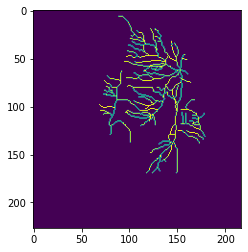

In [23]:
plt.imshow(dilated_mask.T)
plt.show()

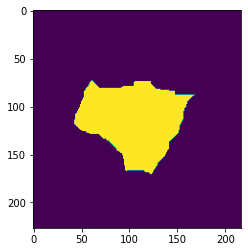

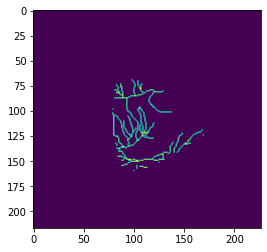

In [24]:

bound, _transform, _proj = read_raster(watershed.bound)
plt.imshow(bound.T)
plt.show()
np.sum(bound), np.prod(bound.shape)

bound_dilated_mask = bound * dilated_mask
plt.imshow(bound_dilated_mask)
plt.show()

In [25]:

dem, _transform, _proj = read_raster(dem_fn)
bound_dem_mask = np.ma.masked_array(dem, mask=np.logical_not(bound_dilated_mask))

print(np.min(bound_dem_mask), np.max(bound_dem_mask), _transform, _proj)

_bound_dem_mask = np.ones(bound_dem_mask.shape) * -9999
indx = np.where(np.logical_not(bound_dem_mask.mask))
_bound_dem_mask[indx] = bound_dem_mask[indx]
write_raster(_join(roads_dir, 'bound_road_dem.tif'), _bound_dem_mask, _proj, _transform, gdal.GDT_Float32, -9999.0)

971.2197875976562 1047.382080078125 (360904.9959394611, 5.0, 0.0, 5364700.2109875195, 0.0, -5.0) +proj=utm +zone=11 +datum=WGS84 +units=m +no_defs


In [26]:
channels, _transform_nf, _proj_nf = read_raster(watershed.netful)
print(channels.shape, _transform_nf, _proj_nf)

subwta, _transform_nf, _proj_nf = read_raster(watershed.subwta)
print(subwta.shape, _transform_nf, _proj_nf)

(217, 227) (360905.0, 5.0, 0.0, 5364700.0, 0.0, -5.0) +proj=utm +zone=11 +datum=WGS84 +units=m +no_defs
(217, 227) (360905.0, 5.0, 0.0, 5364700.0, 0.0, -5.0) +proj=utm +zone=11 +datum=WGS84 +units=m +no_defs


In [27]:
px, py = np.unravel_index(np.argmax(bound_dem_mask, axis=None), bound_dem_mask.shape)

from wepppy.all_your_base.geo import GeoTransformer
geo_transformer = GeoTransformer(src_proj4=_proj, dst_epsg=4326)
geo_transformer.transform(_transform[0] + _transform[1] * px, 
                          _transform[3] + _transform[5] * py)

(-118.874874249589, 48.416437358177)

In [29]:
def unmasked_neighbors(a, indx):
    global _transform, geo_transformer, channels
    
    px, py = indx
    mask = a.mask
    w, h = mask.shape
    
    _unmasked = []
    
    # west
    if px > 0:
        if not mask[px-1, py]:
            _unmasked.append(dict(direction='west', indx=(px-1, py)))
    # east
    if px < w-1:
        if not mask[px+1, py]:
            _unmasked.append(dict(direction='east', indx=(px+1, py)))
    
    # north
    if py > 0:
        if not mask[px, py-1]:
            _unmasked.append(dict(direction='north', indx=(px, py-1)))
        
    # south
    if py < h-1:
        if not mask[px, py+1]:
            _unmasked.append(dict(direction='south', indx=(px, py+1)))
    
    # northwest
    if px > 0 and py > 0:
        if not mask[px-1, py-1]:
            _unmasked.append(dict(direction='northwest', indx=(px-1, py-1)))
            
    # southeast
    if px < w-1 and py < h-1:
        if not mask[px+1, py+1]:
            _unmasked.append(dict(direction='southeast', indx=(px+1, py+1)))
            
    # northeast
    if px < w-1 and py < 0:
        if not mask[px-1, py+1]:
            _unmasked.append(dict(direction='northeast', indx=(px+1, py-1)))
            
    # southwest
    if px > 0 and py < h-1:
        if not mask[px-1, py+1]:
            _unmasked.append(dict(direction='southwest', indx=(px-1, py+1)))
                                  
                                  
    for i in range(len(_unmasked)):
        px, py = _unmasked[i]['indx']
        _unmasked[i].update(dict(elevation=a[px, py],
                                 wgs=geo_transformer.transform(_transform[0] + _transform[1] * px, 
                                                               _transform[3] + _transform[5] * py),
                                 is_channel=channels[px, py] == 1,
                                 topaz_id=subwta[px, py]))
            
    return sorted(_unmasked, key=itemgetter('elevation'), reverse=True) 
        

# walk skidtrails downhill

a = bound_dem_mask

skidtrails = []
while np.prod(bound_dem_mask.shape) > np.sum(bound_dem_mask.mask):
    # find highest point
    trail = []
    
    select = True
    tmp_mask = []
    while select:
        max_elev = np.max(bound_dem_mask)

        # pop skid origin
        px, py = indx = np.unravel_index(np.argmax(a, axis=None), a.shape)
        _unmasked = unmasked_neighbors(a, indx)
        len_unmasked = len(_unmasked)
        
        if len_unmasked == 1:
            select = False
        else:
            tmp_mask.append(indx)
            a.mask[indx] = True
            
    for indx in tmp_mask:
        a.mask[indx] = False

    trail.append(dict(direction='origin', indx=indx, elevation=max_elev,
                      wgs=geo_transformer.transform(_transform[0] + _transform[1] * px, 
                                                    _transform[3] + _transform[5] * py),
                      is_channel=channels[px, py] == 1))

    print(trail[-1])

    stop = False

    while not stop:
        _unmasked = unmasked_neighbors(a, indx)
        len_unmasked = len(_unmasked)

        # no neighbors are skid trails
        if len_unmasked == 0:
            print('s', _unmasked, len_unmasked, np.prod(bound_dem_mask.shape), np.sum(bound_dem_mask.mask))
            stop = True
            indx = _unmasked[0]['indx']
            a.mask[indx] = True

        # one neighbor is skid trail
        elif len_unmasked == 1:
            trail.append(_unmasked[0])
            print(trail[-1])
            
            # pop skid pixel
            indx = _unmasked[0]['indx']
            a.mask[indx] = True

        elif len_unmasked > 1:
            print('s', _unmasked, len_unmasked, np.prod(bound_dem_mask.shape), np.sum(bound_dem_mask.mask))
            trail.append(_unmasked[0])
            
            # pop skid pixel
            indx = _unmasked[0]['indx']
            a.mask[indx] = True
            stop = True

    skidtrails.append(trail)

{'direction': 'origin', 'indx': (73, 108), 'elevation': 1033.4320068359375, 'wgs': (-118.874460757666, 48.416219169521), 'is_channel': False}
s [] 0 49259 48667
{'direction': 'origin', 'indx': (73, 108), 'elevation': 1033.4320068359375, 'wgs': (-118.874460757666, 48.416219169521), 'is_channel': False}
s [] 0 49259 48667
{'direction': 'origin', 'indx': (73, 108), 'elevation': 1033.4320068359375, 'wgs': (-118.874460757666, 48.416219169521), 'is_channel': False}
s [] 0 49259 48667
{'direction': 'origin', 'indx': (73, 108), 'elevation': 1033.4320068359375, 'wgs': (-118.874460757666, 48.416219169521), 'is_channel': False}
s [] 0 49259 48667
{'direction': 'origin', 'indx': (73, 108), 'elevation': 1033.4320068359375, 'wgs': (-118.874460757666, 48.416219169521), 'is_channel': False}
s [] 0 49259 48667
{'direction': 'origin', 'indx': (73, 108), 'elevation': 1033.4320068359375, 'wgs': (-118.874460757666, 48.416219169521), 'is_channel': False}
s [] 0 49259 48667
{'direction': 'origin', 'indx': (7

{'direction': 'origin', 'indx': (73, 108), 'elevation': 1033.4320068359375, 'wgs': (-118.874460757666, 48.416219169521), 'is_channel': False}
s [] 0 49259 48667
{'direction': 'origin', 'indx': (73, 108), 'elevation': 1033.4320068359375, 'wgs': (-118.874460757666, 48.416219169521), 'is_channel': False}
s [] 0 49259 48667
{'direction': 'origin', 'indx': (73, 108), 'elevation': 1033.4320068359375, 'wgs': (-118.874460757666, 48.416219169521), 'is_channel': False}
s [] 0 49259 48667
{'direction': 'origin', 'indx': (73, 108), 'elevation': 1033.4320068359375, 'wgs': (-118.874460757666, 48.416219169521), 'is_channel': False}
s [] 0 49259 48667
{'direction': 'origin', 'indx': (73, 108), 'elevation': 1033.4320068359375, 'wgs': (-118.874460757666, 48.416219169521), 'is_channel': False}
s [] 0 49259 48667
{'direction': 'origin', 'indx': (73, 108), 'elevation': 1033.4320068359375, 'wgs': (-118.874460757666, 48.416219169521), 'is_channel': False}
s [] 0 49259 48667
{'direction': 'origin', 'indx': (7

KeyboardInterrupt: 

In [ ]:
len(skidtrails)
skidtrails[0]

In [ ]:
import geojson
from geojson.geometry import LineString
from geojson import FeatureCollection

fc = FeatureCollection([LineString([point['wgs'] for point in trail]) for trail in skidtrails])

with open(_join(roads_dir,'skidtrails.geojson'), 'w') as fp:
    fp.write(geojson.dumps(fc))

In [ ]:
m2 = Map(
    basemap=basemap_to_tiles(basemaps.Esri.WorldTopoMap),
    center=ron.map.center[::-1],
    zoom=ron.map.zoom,
    layout=Layout(width='100%', height='1000px')
    )


# Skid Trials
skid_trials_fn = _join(roads_dir,'skidtrails.geojson')
with open(skid_trials_fn) as fp:
    skid_trails = json.load(fp)
    
skid_trails_geojson = GeoJSON(
    data=skid_trails,
    style={
        'opacity': 1, 'fillOpacity': 0.1, 'weight': 1, 'color': 'pink'
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5
    }, name='Segmented Skid Trails'
)
m2.add_layer(skid_trails_geojson)


# Skid Trials
skid_trials_fn = '/geodata/salvage_logging/north_star/Skid_segments.wgs.geojson'
with open(skid_trials_fn) as fp:
    skid_trails = json.load(fp)
    
skid_trails_geojson = GeoJSON(
    data=skid_trails,
    style={
        'opacity': 1, 'fillOpacity': 0.1, 'weight': 2, 'color': 'purple'
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5
    }, name='Skid Trails'
)
m2.add_layer(skid_trails_geojson)

# Channels
with open(watershed.channels_shp) as fp:
    channels = json.load(fp)
    
channels_geojson = GeoJSON(
    data=channels,
    style={
        'opacity': 1, 'fillOpacity': 0.1, 'weight': 1, 'color': 'blue'
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5
    }, name='Channels'
)
m2.add_layer(channels_geojson)


# Subcatchments
with open(watershed.subwta_shp) as fp:
    subcatchments = json.load(fp)
    
subcatchments_geojson = GeoJSON(
    data=subcatchments,
    style={
        'opacity': 1, 'fillOpacity': 0.1, 'weight': 1, 'color': 'orange'
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5
    }, name='SubCatchments'
)
m2.add_layer(subcatchments_geojson)

import base64

with open(_join(roads_dir, 'bound_road_dem.tif'), 'rb') as fp:
    base64_encoded = base64.b64encode(fp.read())
    
bounds = [(ron.extent[0], ron.extent[1]), 
          (ron.extent[2], ron.extent[3])]

image = ImageOverlay(
    url="data:image/png;base64," + base64_encoded.decode(),
    bounds=bounds,
    name='skid_raster'
)

m2.add_layer(image)

# Layers Control
control = LayersControl(position='topright')
m2.add_control(control)

In [ ]:
m2

In [ ]:
import matplotlib
matplotlib.__version__

In [ ]:

function roadSegmentRaster($workingDir,$zone)
{
  global $globgisdir,$globPythonBin;




  // Set the cell size of the road grid in meters. We will interpolate the 30m or 10m dem to this cell size when 
  // generating the roads slope.
  $roadGridResolution = 5;

  // create a grid file that only contains the extent of the watershed boundary, we only need to get the roads that are inside the watershed. 
  // This is initially filled with nodata (-9999)
  $boundFile = $workingDir . "/BOUND.ARC";
  $smallFile = $workingDir . "/roads/roadgrid.asc";
  $cmd = "/home/wepp/wepp/makesmall " . $boundFile . " " . $smallFile;
  system($cmd);

  echo("<br>Step 2:" . $cmd . "<br>-----------------------<br>");

  $boundSmall = $workingDir . "/roads/boundsmall.asc";
  copy($smallFile,$boundSmall);

  // find extents for only the watershed
  $dem_extentsmr = getExtent($boundSmall, $workingDir . "/deminfosmr.txt");

  $boundSmalltif = $workingDir . "/roads/boundsmall.tif";
  if (file_exists($boundSmalltif))
    unlink($boundSmalltif);

  if (file_exists($boundSmall))
     unlink($boundSmall);

  // Create a TIFF file with the watershed boundary as the maximum extent, inside initialized to 1's
  $cmd = $globPythonBin .  "gdal_merge.py -init -9999  -o " . $boundSmalltif . " -ul_lr " . $dem_extentsmr . " " . $boundFile;
  system($cmd);

  echo("<br>Step 3:" . $cmd . "<br>-----------------------<br>");

  // translate the small watershed TIFF boundary file into ascii.
  $cmd  = "gdal_translate -of AAIGrid -a_nodata 0 " . $boundSmalltif . " " . $boundSmall;
  system($cmd);
  echo("<br>Step 4:" . $cmd . "<br>------------------------<br>");

  $boundSmallSave = $workingDir . "/roads/boundsmall_save.asc";
  copy($boundSmall,$boundSmallSave);

  // create a tiff template, data will be all undefined, see GDAL library
  $outFile = $workingDir . "/roads/roadgridsegsA.tif";
  $inFile =  $workingDir . "/roads/roadgrid.asc";
  $cmd = "gdal_translate -ot Int32 -a_srs " . $srs . " -a_ullr  " . $dem_extentsmr . " " . $inFile . " " . $outFile;
  system($cmd);
  echo("<br>Step 5:" . $cmd . "<br>------------------------<br>");

  // Set the cell size of the road grid in meters. We will interpolate the 30m or 10m dem to this cell size when
  // generating the roads slope.
  $roadGridResolution = 5;
 
  //
  //------------- Road segment extraction ----------------------
  //

  // Make this a more detailed grid
  $outFile5m = $workingDir . "/roads/roadgridsegs.tif";
  if (file_exists($outFile5m))
       unlink($outFile5m);

  $cmd = "gdalwarp -tr " . $roadGridResolution . " " . $roadGridResolution . " " . $outFile . " " . $outFile5m;
  system($cmd);
  echo("<br>Step 6:" . $cmd . "<br>------------------------<br>");

  // burn in with FID, from the vector data this will give road segments 
  $shapeFile = $workingDir . "/roads/roadsUTM.shp";
  $outFile = $workingDir . "/roads/roadgridsegs.tif";
  $cmd = "gdal_rasterize -l roadsUTM  -a OBJECTID " . $shapeFile . " " . $outFile;
  system($cmd);
  echo("<br> Step 7:" . $cmd . "<br>------------------------<br>");

 // roadgridsegs.tif now contains all the road segment ID's for the roads and their position on the landscape
 // convert it back into an ascii grid to work with
 $tifFile = $workingDir . "/roads/roadgridsegs.tif";
 $outFile = $workingDir . "/roads/roadgridsegs.asc";
 $cmd = "gdal_translate -of AAIGrid " . $tifFile . " " . $outFile;
 system($cmd);
 echo("<br>Step 8:" . $cmd . "<br>------------------------<br>");

 // Generate a more detailed grid of the watershed boundary
 $inFile = $boundSmalltif;
 $outFile = $workingDir . "/roads/boundsmallDet.tif";
 if (file_exists($outFile))
    unlink($outFile);
 $cmd = "gdalwarp -tr " . $roadGridResolution . " " . $roadGridResolution . " " . $inFile . " " . $outFile;
 system($cmd);
 echo("<br>Step 9:" . $cmd . "<br>------------------------<br>");

$inFile =   $workingDir . "/roads/boundsmallDet.tif";
 $boundSmall5m = $workingDir . "/roads/boundsmallDet.asc";
 // translate the detailed boundary into ascii.
 $cmd  = "gdal_translate -of AAIGrid -a_nodata 0 " . $inFile . " " . $boundSmall5m;
 system($cmd);
 echo("<br>Step 10:" . $cmd . "<br>------------------------<br>");

 // clip out the ids that are outside the watershed boundary to make for faster queries, maskgrid is custom c++ program
 $sgrid = $workingDir . "/roads/roadgridsegs.asc";
 $bgrid = $workingDir . "/roads/boundsmallDet.asc";
 $outgrid = $workingDir . "/roads/roadgridsegs2.asc";
 $cmd = "/home/wepp/wepp/maskgrid " . $sgrid . " " . $bgrid . " " . $outgrid;
 system($cmd);
 echo("<br>Step 11:" . $cmd . "<br>");

 // scan the ascii grid files to get all the unique road ids, getids is a custom c++ program
 $idFile = $workingDir . "/roads/roadids.txt";
 $inFile = $workingDir . "/roads/roadgridsegs2.asc";
 $cmd = "/home/wepp/wepp/getids " . $inFile . " " . $idFile;
 system($cmd);
 echo("<br>Step 12:" . $cmd . "<br>");


 getRoadTypes($idFile,$workingDir);


 //
 //-------------- Road type extraction ---------------------------
 // This is just for information, the types are found by using the SQL statement in the function getTypeFromID().
 //

 // create a tiff template, data will be all undefined, see GDAL library
 $outFile = $workingDir . "/roads/roadgridtypesA.tif";
 $inFile =  $workingDir . "/roads/roadgrid.asc";
 $cmd = "gdal_translate -ot Int32 -a_srs " . $srs . " -a_ullr  " . $dem_extentsmr . " " . $inFile . " " . $outFile;
 system($cmd);
 echo("<br>Step 13:" . $cmd . "<br>------------------------<br>");

 // Make this a more detailed grid
 $outFile5m = $workingDir . "/roads/roadgridtypes.tif";
 if (file_exists($outFile5m))
    unlink($outFile5m);

 $cmd = "gdalwarp -tr " . $roadGridResolution . " " . $roadGridResolution . " " . $outFile . " " . $outFile5m;
 system($cmd);
 echo("<br>Step 14:" . $cmd . "<br>------------------------<br>");

 // create a tiff template, data will be all undefined, see GDAL library
 $outFile = $workingDir . "/roads/roadgridtypes.tif";
 $inFile =  $workingDir . "/roads/roadgrid.asc";
 $cmd = "gdal_translate -ot Int32 -a_srs " . $srs . " " . $inFile . " " . $outFile;
 system($cmd);
 echo("<br>Step 15:" . $cmd . "<br>------------------------<br>");

  // create a second raster burn in with FCSUBTYPE, this will give the road type
  $shapefile = $workingDir . "/roads/roadsUTM.shp";
  $outFile = $workingDir . "/roads/roadgridtypes.tif";
  $cmd = "gdal_rasterize -l roadsUTM -a FCSUBTYPE " . $shapefile . " " . $outFile;
  system($cmd);
  echo("<br>Step 16:" . $cmd . "<br>------------------------<br>");

  // roadgridtypes.tif now contains all the road segment types for the roads and their position on the landscape
  // convert it back into an ascii grid to work with
  $tifFile = $workingDir . "/roads/roadgridtypes.tif";
  $outFile = $workingDir . "/roads/roadgridtypes.asc";
  $cmd = "gdal_translate -of AAIGrid " . $tifFile . " " . $outFile;
  system($cmd);
  echo("<br>Step 17:" . $cmd . "<br>------------------------<br>");

 // clip out the ids that are outside the watershed boundary to make for faster queries, maskgrid is custom c++ program
 $sgrid = $workingDir . "/roads/roadgridtypes.asc";
 $bgrid = $workingDir .  "/roads/boundsmallDet.asc"; 
 $outgrid = $workingDir . "/roads/roadgridtypes2.asc";
 $cmd = "/home/wepp/wepp/maskgrid " . $sgrid . " " . $bgrid . " " . $outgrid;
 system($cmd);
 echo("<br>Step 18:" . $cmd . "<br>");

//
//---------------------------- Interpolated DEM ---------------------------------
//
 $boundFile = $workingDir . "/BOUND.ARC";
 $smallFile = $workingDir . "/roads/dem30m.asc";
 if (file_exists($smallFile))
      unlink($smallFile);

 $cmd = "/home/wepp/wepp/makesmall " . $boundFile . " " . $smallFile;
 system($cmd);

 $demSmalltif = $workingDir . "/roads/boundsmallDEM.tif";
 if (file_exists($demSmalltif))
    unlink($demSmalltif);

// convert the relief output file from an ascii to tif
$inFile = $workingDir . "/RELIEF.ARC";
$outFile = $workingDir . "/relief.tif";
$cmd = $cmd = "gdal_translate -of GTiff " . $inFile . " " . $outFile;
system($cmd);

$elevFile = $workingDir . "/relief.tif";
 // Create a TIFF file with the watershed boundary as the maximum extent, inside initialized to elevations 
 $cmd = $globPythonBin .  "gdal_merge.py -init -9999  -o " . $demSmalltif . " -ul_lr " . $dem_extentsmr . " " . $elevFile;
 system($cmd);
 echo("<br>Step 19:" . $cmd . "<br>------------------------<br>");


// interpolate the DEM down to 5m
 $inFile = $workingDir . "/roads/boundsmallDEM.tif";
 $outFile5m = $workingDir . "/roads/dem5m.tif";
 if (file_exists($outFile5m))
     unlink($outFile5m);

 $cmd = "gdalwarp -r cubicspline -tr " . $roadGridResolution . " " . $roadGridResolution . " " . $inFile . " " . $outFile5m;
 system($cmd);
 echo("<br>Step 19:" . $cmd . "<br>------------------------<br>");

// convert the 5m dem back to ascii to work with
 $outFile = $workingDir . "/roads/dem5m.asc";
 $inFile =  $workingDir . "/roads/dem5m.tif";
 $cmd = "gdal_translate -of AAIGrid " . $inFile . " " . $outFile;
 system($cmd);
 echo("<br>Step 20:" . $cmd . "<br>------------------------<br>");

  $outFile = $workingDir . "/roads/roadgridsegs2.tif";
  $inFile =  $workingDir . "/roads/roadgridsegs2.asc";
  $cmd = "gdal_translate -of GTiff " . $inFile . " " . $outFile;
  system($cmd);

  // find extents 
  $roadExtent = getExtent($inFile, $workingDir . "/roads/road5mext.txt");

  //$inFile = $workingDir . "/roads/roadgridsegs2.tif";
  //$inFile2 = $workingDir . "/NETFUL.tif";
  $outFile = $workingDir . "/roads/netful2.tif";
  $inFile = $workingDir . "/NETFUL.tif";

   if (file_exists($outFile))
     unlink($outFile);
  
  // create a 5m resolution channel grid
  $cmd = "gdalwarp -srcnodata 0 -r bilinear -tr " . $roadGridResolution . " " . $roadGridResolution . " " . $inFile . " " . $outFile;
  system($cmd);

  $inFile = $workingDir . "/roads/roadgridsegs2.tif";
  $inFile2 = $workingDir . "/roads/netful2.tif";
  $outFile = $workingDir . "/roads/chanMerged.tif";

   if (file_exists($outFile))
        unlink($outFile);

  // make the grid the same extent as the road file 
  $cmd = $globPythonBin .  "gdal_merge.py -of GTiff -init -9999 -o " . $outFile . " -ul_lr " . $roadExtent . " " . $inFile . " " . $inFile2;
  system($cmd);
  echo("<br>Step 21:" . $cmd . "<b>------------------------------<br>");

  // convert back to ascii to work with
  $outFile = $workingDir . "/roads/chanMerged.asc";
  $inFile =  $workingDir . "/roads/chanMerged.tif";
  $cmd = "gdal_translate -of AAIGrid " . $inFile . " " . $outFile;
  system($cmd);
  echo("<br>Step 22:" . $cmd . "<br>------------------------<br>");

 getSegmentElevations($workingDir);


 makeRoadProfileGraphs($workingDir);

}
